In [1]:
from pyAudioAnalysis import audioTrainTest as aT
from pyAudioAnalysis import MidTermFeatures as aF
from pyAudioAnalysis import audioAnalysis as aA
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import sklearn.svm


In [2]:
directory_in_str = "emotionData/Individual"
pathlist = Path(directory_in_str).glob('**/*.wav')

listOfDirs = []
for path in pathlist:
    path_in_str = str(path)
    parent = path.parents[0]
    if str(parent) not in listOfDirs:
        listOfDirs.append(str(parent))

mtWin = 1.0
mtStep = 1.0
stWin = aT.shortTermWindow
stStep = aT.shortTermStep
classifierType = "svm"
modelName = "models/svm_1v1_1.0.0"
beat = False

In [3]:
features, class_names, file_names, feature_names = aF.multiple_directory_feature_extraction(listOfDirs, mtWin, mtStep, stWin, stStep, beat)

ation\Voice_Mary_Admiration_46.wav
Analyzing file 43 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_47.wav
Analyzing file 44 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_48.wav
Analyzing file 45 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_49.wav
Analyzing file 46 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_5.wav
Analyzing file 47 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_50.wav
Analyzing file 48 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_51.wav
Analyzing file 49 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_52.wav
Analyzing file 50 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_53.wav
Analyzing file 51 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_54.wav
Analyzing file 52 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_55.wav
Analyzing file 53 of 96: emotionData\Individual\Admiration\Voice_Mary_Admiration_56.wa

In [4]:
print(np.array(features).shape)
print(features[0].shape)
print(class_names)
print()
print(feature_names[0])
print(feature_names[0].index('zcr_std'))
print(len(feature_names))

(20,)
(96, 136)
['Admiration', 'Amusement', 'Anger', 'Compassion', 'Contempt', 'Contentment', 'Disappointment', 'Disgust', 'Fear', 'Guilt', 'Hate', 'Interest', 'Joy', 'Love', 'Pleasure', 'Pride', 'Regret', 'Relief', 'Sadness', 'Shame']

['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean', 'del

In [5]:
def classifier_wrapper(classifier, classifier_type, test_sample):
    """
    This function is used as a wrapper to pattern classification.
    ARGUMENTS:
        - classifier:        a classifier object of type sklearn.svm.SVC or 
                             kNN (defined in this library) or sklearn.ensemble.
                             RandomForestClassifier or sklearn.ensemble.
                             GradientBoostingClassifier  or 
                             sklearn.ensemble.ExtraTreesClassifier
        - classifier_type:   "svm" or "knn" or "randomforests" or 
                             "gradientboosting" or "extratrees"
        - test_sample:        a feature vector (np array)
    RETURNS:
        - R:            class ID
        - P:            probability estimate

    EXAMPLE (for some audio signal stored in array x):
        import audioFeatureExtraction as aF
        import audioTrainTest as aT
        # load the classifier (here SVM, for kNN use load_model_knn instead):
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step] =
        aT.load_model(model_name)
        # mid-term feature extraction:
        [mt_features, _, _] = aF.mtFeatureExtraction(x, Fs, mt_win * Fs,
        mt_step * Fs, round(Fs*st_win), round(Fs*st_step));
        # feature normalization:
        curFV = (mt_features[:, i] - MEAN) / STD;
        # classification
        [Result, P] = classifierWrapper(classifier, model_type, curFV)
    """
    class_id = -1
    probability = -1
    if classifier_type == "knn":
        class_id, probability = classifier.classify(test_sample)
    elif classifier_type == "svm" or \
            classifier_type == "randomforest" or \
            classifier_type == "gradientboosting" or \
            classifier_type == "extratrees" or \
            classifier_type == "svm_rbf":
        # print('classifier', classifier)
        # print('test_sample', test_sample)
        # print('test_sample.reshape(1, -1)[0]', test_sample.reshape(1, -1))
        class_id = classifier.predict(test_sample.reshape(1, -1))
        probability = 1 #classifier.predict_proba(test_sample.reshape(1, -1))[0]
        # print('class_id', class_id)
    return np.argmax(class_id), probability

In [6]:
def train_svm(features, c_param, kernel='linear'):
    """
    Train a multi-class probabilitistic SVM classifier.
    Note:     This function is simply a wrapper to the sklearn functionality 
              for SVM training
              See function trainSVM_feature() to use a wrapper on both the 
              feature extraction and the SVM training
              (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements 
                            containt np matrices of features  each matrix 
                            features[i] of class i is 
                            [n_samples x numOfDimensions]
        - c_param:           SVM parameter C (cost of constraints violation)
    RETURNS:
        - svm:              the trained SVM variable

    NOTE:
        This function trains a linear-kernel SVM for a given C value.
        For a different kernel, other types of parameters should be provided.
    """

    feature_matrix, labels = aT.features_to_matrix(features)
    # print(feature_matrix.shape)
    model = tf.keras.Sequential([
        tf.keras.Input(feature_matrix.shape[1]),
        tf.keras.layers.Dense(136, activation="relu"),
        tf.keras.layers.Dense(136, activation="relu"),
        tf.keras.layers.Dense(20),
    ])   
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    model.fit(feature_matrix, labels, epochs=5, verbose=0)
    # model.summary()
    return model

    # feature_matrix, labels = aT.features_to_matrix(features)
    # svm = sklearn.svm.SVC(C=c_param, kernel=kernel, probability=True,
    #                       gamma='auto')
    # svm.fit(feature_matrix, labels)

    # return svm


In [7]:
def evaluate_classifier(features, class_names, n_exp, classifier_name, params,
                        parameter_mode, train_percentage=0.90):
    """
    ARGUMENTS:
        features:     a list ([numOfClasses x 1]) whose elements containt
                      np matrices of features. Each matrix features[i] of
                      class i is [n_samples x numOfDimensions]
        class_names:    list of class names (strings)
        n_exp:        number of cross-validation experiments
        classifier_name: svm or knn or randomforest
        params:        list of classifier parameters (for parameter
                       tuning during cross-validation)
        parameter_mode:    0: choose parameters that lead to maximum overall
                             classification ACCURACY
                          1: choose parameters that lead to maximum overall
                          f1 MEASURE
    RETURNS:
         bestParam:    the value of the input parameter that optimizes the
         selected performance measure
    """

    # feature normalization:
    features_norm, MEAN, STD = aT.normalize_features(features)
    # features_norm = features;
    n_classes = len(features)
    ac_all = []
    f1_all = []
    pre_class_all = []
    rec_classes_all = []
    f1_classes_all = []
    cms_all = []

    # compute total number of samples:
    n_samples_total = 0
    for f in features:
        n_samples_total += f.shape[0]
    if n_samples_total > 10000 and n_exp > 2:
        n_exp = 2
        print("Number of training experiments changed to 2 due to "
              "very high number of samples")
    elif n_samples_total > 2000 and n_exp > 5:
        n_exp = 5
        print("Number of training experiments changed to 5 due to "
              "high number of samples")
    elif n_samples_total > 1000 and n_exp > 10:
        n_exp = 10
        print("Number of training experiments changed to 10 due to "
              "high number of samples")

    for Ci, C in enumerate(params):
        # for each param value
        cm = np.zeros((n_classes, n_classes))
        for e in range(n_exp):
            # for each cross-validation iteration:
            # print("Param = {0:.5f} - classifier Evaluation "
            #       "Experiment {1:d} of {2:d}".format(C, e+1, n_exp))
            # split features:
            f_train, f_test = aT.random_split_features(features_norm,
                                                    train_percentage)
            # train multi-class svms:
            if classifier_name == "svm":
                classifier = train_svm(f_train, C)
            elif classifier_name == "svm_rbf":
                classifier = train_svm(f_train, C, kernel='rbf')
            elif classifier_name == "knn":
                classifier = train_knn(f_train, C)
            elif classifier_name == "randomforest":
                classifier = train_random_forest(f_train, C)
            elif classifier_name == "gradientboosting":
                classifier = train_gradient_boosting(f_train, C)
            elif classifier_name == "extratrees":
                classifier = train_extra_trees(f_train, C)

            cmt = np.zeros((n_classes, n_classes))
            for c1 in range(n_classes):
                n_test_samples = len(f_test[c1])
                res = np.zeros((n_test_samples, 1))
                for ss in range(n_test_samples):
                    res[ss], _ = classifier_wrapper(classifier,
                                                    classifier_name,
                                                    f_test[c1][ss])
                for c2 in range(n_classes):
                    cmt[c1][c2] = float(len(np.nonzero(res == c2)[0]))
            cm = cm + cmt
        cm = cm + 0.0000000010
        rec = np.zeros((cm.shape[0], ))
        pre = np.zeros((cm.shape[0], ))

        for ci in range(cm.shape[0]):
            rec[ci] = cm[ci, ci] / np.sum(cm[ci, :])
            pre[ci] = cm[ci, ci] / np.sum(cm[:, ci])
        pre_class_all.append(pre)
        rec_classes_all.append(rec)
        f1 = 2 * rec * pre / (rec + pre)
        f1_classes_all.append(f1)
        ac_all.append(np.sum(np.diagonal(cm)) / np.sum(cm))

        cms_all.append(cm)
        f1_all.append(np.mean(f1))

    print("\t\t", end="")
    for i, c in enumerate(class_names):
        if i == len(class_names)-1:
            print("{0:s}\t\t".format(c), end="")
        else:
            print("{0:s}\t\t\t".format(c), end="")
    print("OVERALL")
    print("\tC", end="")
    for c in class_names:
        print("\tPRE\tREC\tf1", end="")
    print("\t{0:s}\t{1:s}".format("ACC", "f1"))
    best_ac_ind = np.argmax(ac_all)
    best_f1_ind = np.argmax(f1_all)
    for i in range(len(pre_class_all)):
        print("\t{0:.3f}".format(params[i]), end="")
        for c in range(len(pre_class_all[i])):
            print("\t{0:.1f}\t{1:.1f}\t{2:.1f}".format(100.0 *
                                                       pre_class_all[i][c],
                                                       100.0 *
                                                       rec_classes_all[i][c],
                                                       100.0 *
                                                       f1_classes_all[i][c]),
                  end="")
        print("\t{0:.1f}\t{1:.1f}".format(100.0 * ac_all[i], 100.0 * f1_all[i]),
              end="")
        if i == best_f1_ind:
            print("\t best f1", end="")
        if i == best_ac_ind:
            print("\t best Acc", end="")
        print("")

    if parameter_mode == 0:
        # keep parameters that maximize overall classification accuracy:
        print("Confusion Matrix:")
        aT.print_confusion_matrix(cms_all[best_ac_ind], class_names)
        return params[best_ac_ind], ac_all[best_ac_ind]
    elif parameter_mode == 1:
        # keep parameters that maximize overall f1 measure:
        print("Confusion Matrix:")
        aT.print_confusion_matrix(cms_all[best_f1_ind], class_names)
        return params[best_f1_ind], f1_all[best_f1_ind]

In [8]:
def extract_features_and_train(features, classifier_type, model_name, train_percentage=0.90):

    n_feats = features[0].shape[1]
    feature_names = ["features" + str(d + 1) for d in range(n_feats)]

    # STEP B: classifier Evaluation and Parameter Selection:
    if classifier_type == "svm" or classifier_type == "svm_rbf":
        #classifier_par = np.array([0.001, 0.01,  0.5, 1.0, 5.0, 10.0, 20.0])
        classifier_par = np.array([20.0])
    elif classifier_type == "randomforest":
        classifier_par = np.array([10, 25, 50, 100, 200, 500])
    elif classifier_type == "knn":
        classifier_par = np.array([1, 3, 5, 7, 9, 11, 13, 15])        
    elif classifier_type == "gradientboosting":
        classifier_par = np.array([10, 25, 50, 100, 200, 500])
    elif classifier_type == "extratrees":
        classifier_par = np.array([10, 25, 50, 100, 200, 500])

    # get optimal classifeir parameter:
    temp_features = []
    for feat in features:
        temp = []
        for i in range(feat.shape[0]):
            temp_fv = feat[i, :]
            if (not np.isnan(temp_fv).any()) and (not np.isinf(temp_fv).any()):
                temp.append(temp_fv.tolist())
            else:
                print("NaN Found! Feature vector not used for training")
        temp_features.append(np.array(temp))
    features = temp_features

    best_param, best_score = evaluate_classifier(features, class_names, 1, classifier_type,
                                     classifier_par, 1, train_percentage)

    print("Selected params: {0:.5f}".format(best_param))

    return best_score

In [9]:
features_copy = [features[i] for i in range(len(features))]
feature_names_copy = feature_names[0]

perm_features = []
accuracies = []
perm_feature_names = []

print(features_copy[0].shape)
print(feature_names_copy)

while feature_names_copy:
    temp_accs = []
    for i in range(len(feature_names_copy)):
        print("\nEvaluating {} | {} / {}".format(feature_names_copy[i], i, len(feature_names_copy)))
        if perm_features:
            train_features = [np.concatenate((perm_features[j], features_copy[j][:,i,np.newaxis]), axis=1) for j in range(len(features_copy))]
        else:   
            train_features = [features_copy[j][:,i,np.newaxis] for j in range(len(features_copy))]
        print(train_features[0].shape)
        temp_accs.append(extract_features_and_train(train_features, "svm", "models/tempSvm_1v1_1.0.0"))
    
    best_acc = max(temp_accs)
    best_index = temp_accs.index(best_acc)
    accuracies.append(best_acc)
    if perm_features:
        perm_features = [np.concatenate((perm_features[j], features_copy[j][:,best_index,np.newaxis]), axis=1) for j in range(len(features_copy))]
    else:
        perm_features = [features_copy[j][:,best_index,np.newaxis] for j in range(len(features_copy))]
    features_copy = [np.delete(features[i], best_index, axis=1) for i in range(len(features_copy))]
    added_feature = feature_names_copy.pop(best_index)
    perm_feature_names.append(added_feature)
    print("Adding {} to the perm features".format(added_feature))
    print("New accuracy is {}".format(best_acc))
    print("New Perm Features list is {}".format(perm_feature_names))


22	0.00	0.41	0.82	0.00	0.41	0.00	0.41	0.00	0.00	0.00	0.00	0.41	1.22
Selected params: 20.00000

Evaluating delta chroma_9_std | 10 / 11
(96, 126)
		Admiration			Amusement			Anger			Compassion			Contempt			Contentment			Disappointment			Disgust			Fear			Guilt			Hate			Interest			Joy			Love			Pleasure			Pride			Regret			Relief			Sadness			Shame		OVERALL
	C	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	PRE	REC	f1	ACC	f1
	20.000	50.0	50.0	50.0	66.7	72.7	69.6	57.1	33.3	42.1	35.3	54.5	42.9	50.0	30.8	38.1	30.8	33.3	32.0	38.5	50.0	43.5	64.7	68.7	66.7	58.3	58.3	58.3	69.2	69.2	69.2	45.0	64.3	52.9	50.0	38.5	43.5	60.0	64.3	62.1	28.6	46.2	35.3	44.4	28.6	34.8	60.0	60.0	60.0	50.0	18.2	26.7	71.4	66.7	69.0	25.0	33.3	28.6	25.0	16.7	20.0	48.6	47.3	 best f1	 best Acc
Confusion Matrix:
	Adm	Amu	Ang	Com	Con	Con	Dis	Dis	Fear	Gui	Hate	Int	Joy	Love	Pl

In [10]:
print(accuracies)
print(perm_feature_names)



[0.08020649602529828, 0.12300787126463131, 0.16849925331653506, 0.18921994413542337, 0.21067870138284492, 0.2594949967122988, 0.25696025165783903, 0.27034440681242367, 0.27046975486668695, 0.26982659406894766, 0.314691774984948, 0.33747293791705085, 0.32323729453883704, 0.31997704810186506, 0.338976559433691, 0.3202603858444293, 0.3284160514899897, 0.34472406817344625, 0.3402924236128696, 0.32513511673059176, 0.37049138041446045, 0.364864475704916, 0.3602310839923936, 0.42584826717936963, 0.3969493453960693, 0.41685932703060213, 0.4048369239320708, 0.4495320016449723, 0.4279740594899404, 0.4286107591748083, 0.42794109505659605, 0.4360011937905197, 0.39959299838137713, 0.42071213982496214, 0.4359662057216694, 0.41522410722351466, 0.46172853256293794, 0.4375882582957472, 0.4341688853307463, 0.4399262771715479, 0.448769800627457, 0.4298457749401205, 0.45070025081630505, 0.45055603383329573, 0.4300885520040012, 0.43821574308423966, 0.4211784052250226, 0.41657997000317265, 0.479307995165855

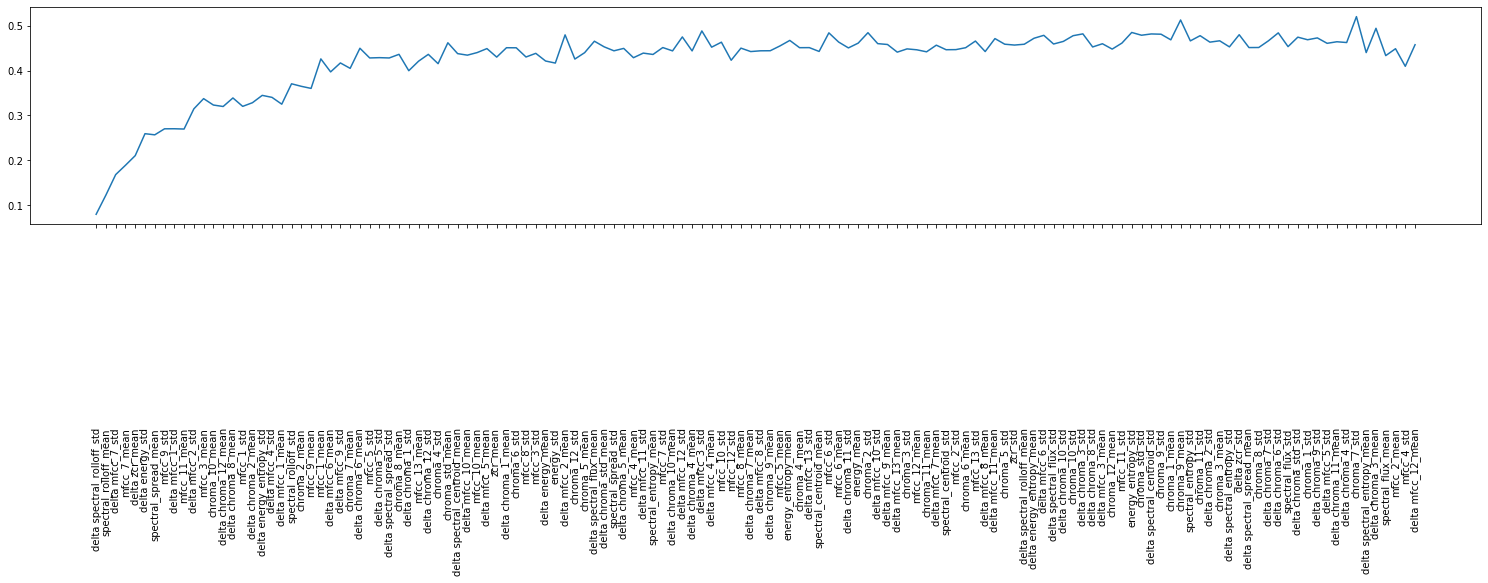

In [43]:
plt.figure(figsize=(26,4))
plt.plot(perm_feature_names, accuracies)
plt.xticks(rotation=90)
plt.show()